##  Seattle Airbnb Data Analysis
* The data are from Kaggle Seattle Airbnb open [data](https://www.kaggle.com/airbnb/seattle/)
* Please unzip the files into ./data folder before running the script
* Following CRISP-DM (Cross-Industry Standard Process for Data Mining) process
  1. Business Understanding
  2. Data Understanding
  3. Data Preparation
  4. Modelling
  5. Evaluation
  6. Deployment

## Business Understanding

By directly connecting visitors and home owners, Airbnb has been able to provide better travel experience with a win-win-win strategy. The visitors could find a better lodging with lower cost. The host could make extra money by renting out their unused spaces. And Airbnb could make commission by connecting the above two. Since its launch in 2008, Airbnb have collected a lot of data related to the listings. Analysis Fof the data could be very helpful for understanding customer behaviors, making business decision, and implementing additional services, etc for both Airbnb and the host. 

In this analysis, I am interested in the following questions: 

    1. What are the available homes for rent across the calendar year?
    2. What are the average rental prices for different months?
    3. What are the obvious factors that could affect the rental price?
    4. Are there any corrections between neighborhood and rental price?
    5. How reviews and rental price correlate?
    
 ## Data Understanding
 
The data are from Kaggle Seattle Airbnb open [data](https://www.kaggle.com/airbnb/seattle/). There are three files: calendar.csv, listings.csv, and reviews.csv. There are ~1.4M records for calendar information such as date and prices; ~3800 records for listing information with associated features; and ~85 records for review entries. The information of these datasets can be found from the following cells. To answer my questions, I am mostly interested in the first two datasets.

In [1]:
# Import relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


In [2]:
# Load three datasets
df_calendar = pd.read_csv("data/calendar.csv")
df_listings = pd.read_csv("data/listings.csv")
df_reviews = pd.read_csv("data/reviews.csv")

In [3]:
# Quickly view the data

print(df_calendar.info())
print(df_listings.info())
print(df_reviews.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3818 non-null   int64  
 1   listing_url                       3818 non-null   object 
 2   scrape_id                         3818 non-null   int64  
 3   last_scraped                      3818 non-null   object 
 4   name                              3818 non-null   object 
 5   summary                    

## Data preparation and analysis

### Analyze calendar dataset

In [4]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [5]:
## We are only interested in the available houses. First we want to check the Null values
## Good news: there are no null values for available houses
df_available = df_calendar[df_calendar.available == 't'].copy()
df_available.isnull().mean()


listing_id    0.0
date          0.0
available     0.0
price         0.0
dtype: float64

In [6]:
# The price contains $ sign and "," for thousands. Write a function to remove them
def clean_price(col):
    """convert price with "$xx,xxx" to float number"""
    col = col.apply(lambda x: float(x[1:].replace(',', '') if type(x) == str else 0))
    return col

# Now we convert price colomns to float numbers
df_available['price'] = clean_price(df_available['price'])


In [7]:
# Since we want to check the monthly dependent rental price, we will add a new column "month_year"
df_available['date'] = df_available['date'].astype(str)
df_available['month_year'] = df_available['date'].apply(lambda x: x[:-3])

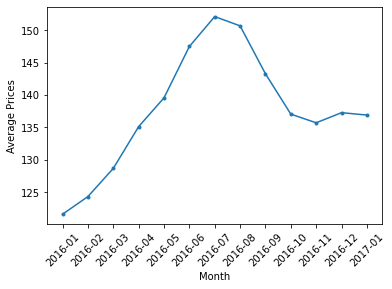

In [8]:
# We then calculate the averaged monthly rental price, and plot them
month_year_price = df_available[['month_year', 'price']].groupby('month_year').mean()
plt.figure()
plt.plot(month_year_price.index, month_year_price.price, '.-')
plt.xlabel("Month")
plt.ylabel("Average Prices")
plt.xticks(rotation=45)
plt.show()

### Learnings

The average rental price increases through the first half year, and reaches the climax in July, then decreases until October of the year. The average price stays flat for the last quarter of the year.

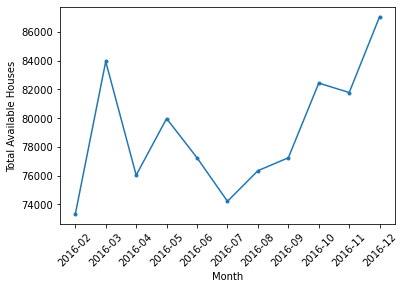

In [9]:
# We count the total available house for each month
month_year_price = df_available[['month_year', 'price']].groupby('month_year').count()
month_year_price = month_year_price[month_year_price.index != "2017-01"]
month_year_price = month_year_price[month_year_price.index != "2016-01"]
plt.figure()
plt.plot(month_year_price.index, month_year_price.price, '.-')
plt.xlabel("Month")
plt.ylabel("Total Available Houses")
plt.xticks(rotation=45)
plt.show()

### Learnings

The number of available houses fluctuate from month to month, with no obvious patterns with respect to the months.

## Data preparation and analysis

###  Analyze listing dataset

In [10]:
# Check the null data

df_listings.isnull().mean().sort_values(ascending=False).head(20)

license                        1.000000
square_feet                    0.974594
monthly_price                  0.602672
security_deposit               0.511262
weekly_price                   0.473808
notes                          0.420639
neighborhood_overview          0.270299
cleaning_fee                   0.269775
transit                        0.244631
host_about                     0.224987
host_acceptance_rate           0.202462
review_scores_accuracy         0.172342
review_scores_checkin          0.172342
review_scores_value            0.171818
review_scores_location         0.171556
review_scores_cleanliness      0.171032
review_scores_communication    0.170508
review_scores_rating           0.169460
last_review                    0.164222
first_review                   0.164222
dtype: float64

### Learnings
Although some features might be important to the listing prices, such as square_feet, the fact that 97% of data are missing prevent any good models with this feature. When people are listing their houses, they simply don't bother to enter the squre feet of the house. Therefore, data imputation on the feature does not make sense.

Monthly price, security deposit, and weekly price are three other features which have ~50% missing data. Since I am interested in listing price prediction, and I don't want to polute the response variables with any price related items. I will purposely exclude these features from the model. For the same reason, I will also exclude cleaning fee from the prediction features.


### Feature selection thoughts

I am interested in predicting the listing price with non-subjective features. As a result, the features such as monthly_price, security_deposit, weekly_price, cleaning_fee will be excluded from the model. Including these features might improve my model accuracy, but it does not help the end users to make a decision. For example, the cleaning_fee is most likely high for a better house which has high rental price (thus it correlates with the rental price well), but it is useless for a host to estimate how much rental price he should put in based on the subjective cleaning_price he added in later.

The features which cannot be easily controlled by the host, such as number of rooms of the house, facilities and amenities of the house, and past reviewers will be of interest for predictions.

In [11]:
# Convert price to float number
df_listings['price'] = clean_price(df_listings['price'] )


In [12]:
# I am intersted in how the amenities affect the rental price. There we
# add new features related to amenities

df_listings['TV'] = df_listings.amenities.str.contains("TV")
df_listings['Internet'] = df_listings.amenities.str.contains("Internet")
df_listings['AC'] = df_listings.amenities.str.contains("Air Conditioning")
df_listings['Washer'] = df_listings.amenities.str.contains("Washer")
df_listings['Kitchen'] = df_listings.amenities.str.contains("Kitchen")
df_listings['Heating'] = df_listings.amenities.str.contains("Heating")
df_listings['Free Parking'] = df_listings.amenities.str.contains("Free Parking on Premises")

<AxesSubplot:>

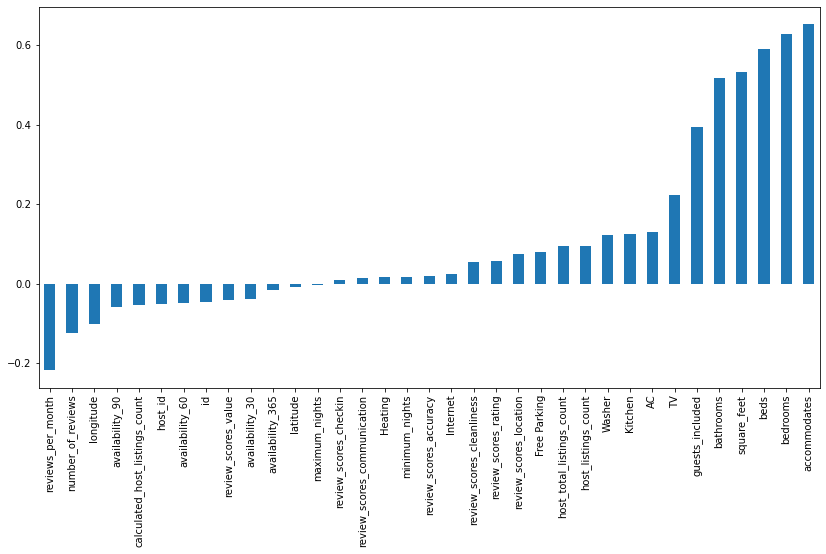

In [13]:
# Now we check obvious features which might correlate with price
plt.figure(figsize=(14, 7))
df_listings.corr()['price'].sort_values()[:-3].plot(kind="bar")

### Learnings

There are some obvious features that correlate with the rental price. Examples include accommodtes, bedrooms beds, the amenities, reviewers, etc. We will choose the most interesting features 

In [14]:
# Based on the above information, we choose the most important feature for future model
# First, we want to check the null values


features_of_interest = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'guests_included', 
                        'TV', 'AC', 'Kitchen', 'Washer', 'host_listings_count', 'Free Parking',
                        'review_scores_rating', 'Internet', 'minimum_nights', 'Heating',
                        'reviews_per_month', 'number_of_reviews'
                       ]

df_listings_sub = df_listings[features_of_interest]
df_listings_sub.isnull().mean()

price                   0.000000
accommodates            0.000000
bedrooms                0.001572
beds                    0.000262
bathrooms               0.004191
guests_included         0.000000
TV                      0.000000
AC                      0.000000
Kitchen                 0.000000
Washer                  0.000000
host_listings_count     0.000524
Free Parking            0.000000
review_scores_rating    0.169460
Internet                0.000000
minimum_nights          0.000000
Heating                 0.000000
reviews_per_month       0.164222
number_of_reviews       0.000000
dtype: float64

### Fillna or dropna thoughts

Of all the features of interest, bedrooms, beds, bathrooms and host_listings_count have <0.5% null values. Review related features have ~17% null values. 

I don't think data imputing is a good idea in this dataset. For example, using a mean review number to impute the null values only obscure the models.

Readers are welcome to use the following code for data imputing. The model does not improve with different types of data imputing. Therefore the null data will be removed.

fill_mean = lambda col: col.fillna(col.mean())
df_listings_sub = df_listings_sub.apply(fill_mean, axis=0) #Fill all missing values with the mean of the column.


<AxesSubplot:>

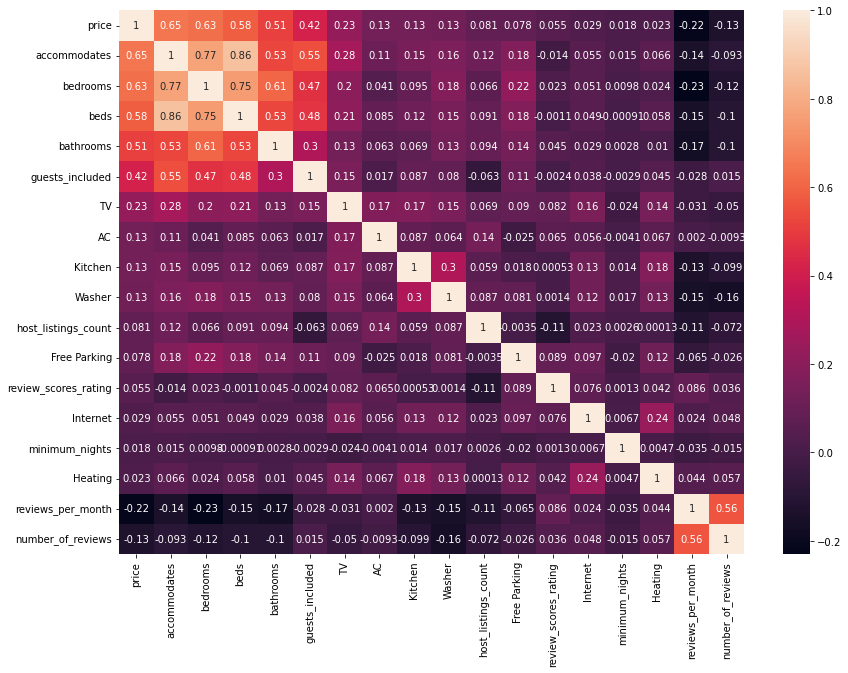

In [15]:
# Check correlation matrix with heatmap for better viewing
df_listings_sub = df_listings_sub.dropna(how='any')
plt.figure(figsize=(14, 10))
sns.heatmap(df_listings_sub.corr(), annot=True)

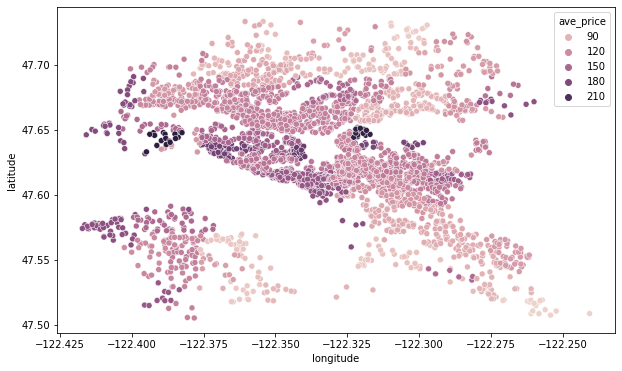

In [16]:
# Neighborhood information was not included in previous analysis
# Question: does price correlate with neighbourhood?

df_listing_neigh = df_listings.groupby(['neighbourhood_cleansed']).mean().reset_index()
df_listing_neigh = df_listing_neigh[['price', 'neighbourhood_cleansed']].rename(columns={'price': 'ave_price'})
df_listing_neigh = pd.merge(df_listings, df_listing_neigh, on='neighbourhood_cleansed', how='left')
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_listing_neigh, x="longitude", y="latitude", hue="ave_price")
plt.show()

In [17]:
# In addition to the above features, we add several categorical data columns: neighborhood, cancellation, instant booking

features_of_interest = ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'guests_included', 
                        'TV', 'AC', 'Kitchen', 'Washer', 'host_listings_count', 'Free Parking',
                        'review_scores_rating', 'Internet', 'minimum_nights', 'Heating',
                       'neighbourhood_group_cleansed', 'cancellation_policy', 'reviews_per_month', 
                        'number_of_reviews', 'instant_bookable'
                       ]


df_listings_sub = df_listings[features_of_interest]

# As discussed before, we will drop null values instead of data imputing
df_listings_sub = df_listings_sub.dropna(how='any')

# one-hot encoding the categorical data
df_listings_sub = pd.get_dummies(df_listings_sub)

<AxesSubplot:>

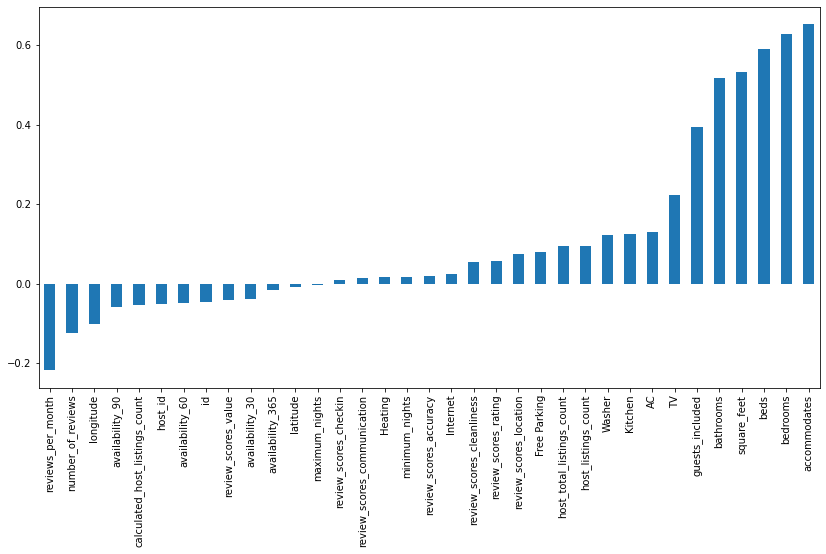

In [18]:
# View the correlation again
plt.figure(figsize=(14, 7))
df_listings.corr()['price'].sort_values()[:-3].plot(kind="bar")

### Modelling

In [19]:

y = df_listings_sub['price']
X = df_listings_sub.drop('price', axis=1)

# Check number of features
print(df_listings_sub.shape)
print(y.shape)
print(X.shape)

# train test dataset split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Instantiate model
lm_model = LinearRegression(normalize=True)

# Fit model
lm_model.fit(X_train, y_train)

# Predict model
y_test_predict = lm_model.predict(X_test)

(3153, 40)
(3153,)
(3153, 39)


### Evaluation

In [20]:

# Check test and training scores
y_train_predict = lm_model.predict(X_train)
test_score = r2_score(y_test, y_test_predict)
train_score = r2_score(y_train, y_train_predict)

print("train score={}, test score={}".format(train_score, test_score))

train score=0.5599329768426022, test score=0.5379392705093353


### Learnings

Both training score and test score are close to each other. Thereis no overfitting issues

### Deployment

The deployment step in  CRISP-DM step will be excluded here.